# Moab Precipitation Analysis

**Dataset:** MeteoBlue History+ data for Moab, Utah (2005-2025)  
**Purpose:** Comprehensive precipitation analysis including seasonal patterns, climatology, and operating period comparisons

---

## Table of Contents
1. Setup and Data Loading
2. Data Cleaning
3. Basic EDA
4. Monthly Analysis
5. Seasonal Analysis (DJF/MAM/JJA/SON + Warm/Cold)
6. Client-Ready Visualizations
7. Operating Period vs Climatology Comparison


---
## 1. Setup and Data Loading


In [ ]:
# =============================================================================
# CONFIGURATION - Modify these parameters as needed
# =============================================================================

# Operating Period Definition (for comparison to climatology)
# Set these to your specific operating period dates
OPERATING_PERIOD_START = "2020-01-01" 
OPERATING_PERIOD_END = "2025-12-31"

# Baseline Climatology Period (typically the full historical record)
CLIMATOLOGY_START = "2005-01-01"
CLIMATOLOGY_END = "2019-12-31"

# Season Definitions
SEASONS = {
    'DJF': [12, 1, 2],   # Winter: December, January, February
    'MAM': [3, 4, 5],    # Spring: March, April, May
    'JJA': [6, 7, 8],    # Summer: June, July, August
    'SON': [9, 10, 11]   # Fall: September, October, November
}

# Warm vs Cold Season Definitions
WARM_MONTHS = [4, 5, 6, 7, 8, 9, 10]  # April - October
COLD_MONTHS = [11, 12, 1, 2, 3]       # November - March


In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style (compatible with different matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        pass  # Use default style if seaborn styles not available

sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [14]:
# File Upload / Path Configuration
# This cell handles both Google Colab and local environments

import os

# Try to detect if running in Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Running in Google Colab - use file upload
    print("Running in Google Colab. Please upload your Moab CSV file:")
    uploaded = files.upload()
    csv_filename = list(uploaded.keys())[0]
    print(f"\nFile uploaded: {csv_filename}")
else:
    # Running locally - specify the file path directly
    # Modify this path if your file is in a different location
    csv_filename = 'Moab_Meteoblue_2005-01_to_2025-12.csv'
    
    # Check if file exists
    if os.path.exists(csv_filename):
        print(f"Running locally. Using file: {csv_filename}")
    else:
        print(f"ERROR: File '{csv_filename}' not found!")
        print("Please update csv_filename with the correct path to your CSV file.")


Running locally. Using file: Moab_Meteoblue_2005-01_to_2025-12.csv


In [15]:
# Alternative file path options:
# 
# For Google Colab with Google Drive:
#   from google.colab import drive
#   drive.mount('/content/drive')
#   csv_filename = '/content/drive/MyDrive/your_path/Moab_Meteoblue_2005-01_to_2025-12.csv'
#
# For local Jupyter:
#   csv_filename = '/full/path/to/Moab_Meteoblue_2005-01_to_2025-12.csv'


In [16]:
def load_meteoblue_csv(filepath, header_row=9):
    """
    Load MeteoBlue History+ CSV file with metadata header rows.
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    header_row : int
        Row number where the actual column headers are (0-indexed)
        MeteoBlue files typically have 9 metadata rows before the header
    
    Returns:
    --------
    pd.DataFrame
        Loaded and parsed dataframe
    """
    # Read the CSV, skipping metadata rows
    df = pd.read_csv(filepath, skiprows=header_row)
    
    # Parse timestamp column
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%dT%H%M')
    
    return df


def clean_column_names(df):
    """
    Simplify long MeteoBlue column names to shorter, cleaner versions.
    
    Example: 'Moab Temperature [2 m elevation corrected]' -> 'Temperature_2m'
    """
    rename_map = {}
    
    for col in df.columns:
        new_name = col
        
        # Remove site prefix (e.g., 'Moab ')
        if col.startswith('Moab '):
            new_name = col.replace('Moab ', '')
        
        # Simplify bracketed qualifiers
        if '[2 m elevation corrected]' in new_name:
            new_name = new_name.replace(' [2 m elevation corrected]', '_2m')
        elif '[850 mb]' in new_name:
            new_name = new_name.replace(' [850 mb]', '_850mb')
        elif '[700 mb]' in new_name:
            new_name = new_name.replace(' [700 mb]', '_700mb')
        elif '[10 m]' in new_name:
            new_name = new_name.replace(' [10 m]', '_10m')
        elif '[2 m]' in new_name:
            new_name = new_name.replace(' [2 m]', '_2m')
        elif '[sfc]' in new_name:
            new_name = new_name.replace(' [sfc]', '')
        elif '[MSL]' in new_name:
            new_name = new_name.replace(' [MSL]', '')
        
        # Remove any remaining brackets
        if '[' in new_name:
            new_name = new_name.split('[')[0].strip()
        
        # Replace spaces with underscores
        new_name = new_name.replace(' ', '_')
        
        rename_map[col] = new_name
    
    return df.rename(columns=rename_map)


# Load the data
print("Loading data...")
df_raw = load_meteoblue_csv(csv_filename)
df = clean_column_names(df_raw)

print(f"\nData loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {list(df.columns)}")


Loading data...

Data loaded successfully!
Shape: 183,384 rows × 25 columns
Date range: 2005-01-01 00:00:00 to 2025-12-02 23:00:00

Columns: ['timestamp', 'Temperature_2m', 'Temperature_850mb', 'Temperature_700mb', 'Precipitation_Total', 'Relative_Humidity_2m', 'Snowfall_Amount', 'Snow_Depth', 'Wind_Gust', 'Wind_Speed_10m', 'Wind_Direction_10m', 'Wind_Speed_850mb', 'Wind_Direction_850mb', 'Wind_Speed_700mb', 'Wind_Direction_700mb', 'Cloud_Cover_Total', 'Cloud_Cover_High', 'Cloud_Cover_Medium', 'Cloud_Cover_Low', 'CAPE', 'Shortwave_Radiation', 'Mean_Sea_Level_Pressure', 'Geopotential_Height_850mb', 'Geopotential_Height_700mb', 'PBL_Height']


In [17]:
# Preview the data
df.head(10)


,timestamp,Temperature_2m,Temperature_850mb,Temperature_700mb,Precipitation_Total,Relative_Humidity_2m,Snowfall_Amount,Snow_Depth,Wind_Gust,Wind_Speed_10m,...,Cloud_Cover_Total,Cloud_Cover_High,Cloud_Cover_Medium,Cloud_Cover_Low,CAPE,Shortwave_Radiation,Mean_Sea_Level_Pressure,Geopotential_Height_850mb,Geopotential_Height_700mb,PBL_Height
0,2005-01-01 00:00:00,10.608969,9.83,-3.26,0.0,45.982550,0.0,0.0,7.7,3.748333,...,45.000000,93.0,45.0,0.0,2.0,41.0,1006.3,1417.0,2992.0,706.0
1,2005-01-01 01:00:00,10.398969,9.39,-3.40,0.0,46.814148,0.0,0.0,7.5,3.008322,...,29.000000,94.0,29.0,0.0,1.0,0.0,1006.4,1416.0,2991.0,387.0
2,2005-01-01 02:00:00,9.248968,8.93,-3.36,0.0,50.964237,0.0,0.0,7.4,2.906888,...,24.600000,82.0,24.0,1.0,0.0,0.0,1006.3,1415.0,2989.0,272.0
3,2005-01-01 03:00:00,9.008968,8.64,-3.34,0.0,54.037460,0.0,0.0,7.9,3.224903,...,21.900002,73.0,21.0,0.0,0.0,0.0,1005.9,1411.0,2986.0,300.0
4,2005-01-01 04:00:00,9.528968,8.56,-3.61,0.0,53.590282,0.0,0.0,8.5,3.807887,...,12.000000,40.0,9.0,5.0,2.0,0.0,1005.9,1411.0,2985.0,449.0
5,2005-01-01 05:00:00,10.148969,8.55,-4.05,0.0,50.812590,0.0,0.0,11.2,4.509989,...,35.000000,2.0,35.0,13.0,14.0,0.0,1006.1,1412.0,2985.0,663.0
6,2005-01-01 06:00:00,10.178968,8.39,-4.71,0.2,58.381046,0.0,0.0,13.7,5.664804,...,43.000000,0.0,43.0,30.0,26.0,0.0,1006.7,1417.0,2986.0,974.0
7,2005-01-01 07:00:00,8.178968,7.36,-5.45,0.0,63.855343,0.0,0.0,12.5,6.449806,...,14.000000,0.0,14.0,14.0,17.0,0.0,1008.1,1425.0,2987.0,1140.0
8,2005-01-01 08:00:00,8.478969,6.67,-5.98,0.0,67.301030,0.0,0.0,12.9,6.435060,...,10.000000,0.0,6.0,10.0,3.0,0.0,1008.9,1428.0,2985.0,1054.0
9,2005-01-01 09:00:00,6.548968,5.77,-6.51,0.0,70.624360,0.0,0.0,12.5,5.830952,...,6.000000,0.0,6.0,6.0,0.0,0.0,1010.1,1433.0,2986.0,861.0


In [18]:
# Identify key columns for analysis
# These may need adjustment based on actual column names after cleaning

# Find precipitation column
precip_col = [c for c in df.columns if 'Precipitation' in c and 'Total' in c]
PRECIP_COL = precip_col[0] if precip_col else 'Precipitation_Total'

# Find temperature column (surface/2m)
temp_col = [c for c in df.columns if 'Temperature' in c and ('2m' in c or '2 m' in c.lower())]
TEMP_COL = temp_col[0] if temp_col else 'Temperature_2m'

# Find snowfall column
snow_col = [c for c in df.columns if 'Snowfall' in c]
SNOW_COL = snow_col[0] if snow_col else 'Snowfall_Amount'

# Find relative humidity column
rh_col = [c for c in df.columns if 'Relative_Humidity' in c or 'Humidity' in c]
RH_COL = rh_col[0] if rh_col else 'Relative_Humidity_2m'

print("Key columns identified:")
print(f"  Precipitation: {PRECIP_COL}")
print(f"  Temperature: {TEMP_COL}")
print(f"  Snowfall: {SNOW_COL}")
print(f"  Relative Humidity: {RH_COL}")


Key columns identified:
  Precipitation: Precipitation_Total
  Temperature: Temperature_2m
  Snowfall: Snowfall_Amount
  Relative Humidity: Relative_Humidity_2m


---
## 2. Data Cleaning


In [19]:
# Check data types
print("Data Types:")
print(df.dtypes)


Data Types:
timestamp                    datetime64[ns]
Temperature_2m                      float64
Temperature_850mb                   float64
Temperature_700mb                   float64
Precipitation_Total                 float64
Relative_Humidity_2m                float64
Snowfall_Amount                     float64
Snow_Depth                          float64
Wind_Gust                           float64
Wind_Speed_10m                      float64
Wind_Direction_10m                  float64
Wind_Speed_850mb                    float64
Wind_Direction_850mb                float64
Wind_Speed_700mb                    float64
Wind_Direction_700mb                float64
Cloud_Cover_Total                   float64
Cloud_Cover_High                    float64
Cloud_Cover_Medium                  float64
Cloud_Cover_Low                     float64
CAPE                                float64
Shortwave_Radiation                 float64
Mean_Sea_Level_Pressure             float64
Geopotential_Height_

In [20]:
# Check for missing values
print("Missing Values Summary (Before Handling):")
print("=" * 50)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_with_values = missing_df[missing_df['Missing Count'] > 0]

if len(missing_with_values) > 0:
    print(missing_with_values)
    print(f"\nTotal missing values: {missing.sum():,}")
else:
    print("✓ No missing values found!")

# =============================================================================
# HANDLE MISSING VALUES BASED ON VARIABLE TYPE
# =============================================================================
print("\n" + "=" * 50)
print("Handling Missing Values by Variable Type:")
print("=" * 50)

# Define variable categories for appropriate handling
ACCUMULATION_VARS = ['Precipitation_Total', 'Snowfall_Amount', 'Snow_Depth']  # Fill with 0
TEMPERATURE_VARS = ['Temperature_2m', 'Temperature_850mb', 'Temperature_700mb']  # Interpolate
WIND_SPEED_VARS = ['Wind_Speed_10m', 'Wind_Speed_850mb', 'Wind_Speed_700mb', 'Wind_Gust']  # Interpolate
WIND_DIR_VARS = ['Wind_Direction_10m', 'Wind_Direction_850mb', 'Wind_Direction_700mb']  # Forward fill
HUMIDITY_VARS = ['Relative_Humidity_2m']  # Interpolate
PRESSURE_HEIGHT_VARS = ['Mean_Sea_Level_Pressure', 'Geopotential_Height_850mb', 
                        'Geopotential_Height_700mb', 'PBL_Height']  # Interpolate
CLOUD_VARS = ['Cloud_Cover_Total', 'Cloud_Cover_High', 'Cloud_Cover_Medium', 'Cloud_Cover_Low']  # Forward fill
RADIATION_VARS = ['Shortwave_Radiation', 'CAPE']  # Fill with 0

handled_count = 0

# 1. Accumulation variables (precip, snow) - Fill with 0
# Rationale: Missing values likely mean no measurement, which typically means no precipitation
for col in ACCUMULATION_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        print(f"  {col}: Filled {n_missing} missing with 0 (accumulation variable)")
        handled_count += n_missing

# 2. Temperature variables - Linear interpolation
# Rationale: Temperature changes gradually; interpolation provides reasonable estimates
for col in TEMPERATURE_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')
        # Fill any remaining edge cases with forward/backward fill
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        print(f"  {col}: Interpolated {n_missing} missing (continuous variable)")
        handled_count += n_missing

# 3. Wind speed variables - Linear interpolation
# Rationale: Wind speed changes gradually; interpolation is appropriate
for col in WIND_SPEED_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        print(f"  {col}: Interpolated {n_missing} missing (wind speed)")
        handled_count += n_missing

# 4. Wind direction variables - Forward fill (circular variable, interpolation not ideal)
# Rationale: Wind direction is circular; forward fill preserves last known direction
for col in WIND_DIR_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].fillna(method='ffill', limit=6).fillna(method='bfill')
        print(f"  {col}: Forward-filled {n_missing} missing (circular variable)")
        handled_count += n_missing

# 5. Humidity variables - Linear interpolation
for col in HUMIDITY_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        print(f"  {col}: Interpolated {n_missing} missing (humidity)")
        handled_count += n_missing

# 6. Pressure and geopotential height - Linear interpolation
# Rationale: These are continuous atmospheric variables
for col in PRESSURE_HEIGHT_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        print(f"  {col}: Interpolated {n_missing} missing (pressure/height)")
        handled_count += n_missing

# 7. Cloud cover - Forward fill
# Rationale: Cloud conditions tend to persist; forward fill is reasonable
for col in CLOUD_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].fillna(method='ffill', limit=6).fillna(method='bfill')
        print(f"  {col}: Forward-filled {n_missing} missing (cloud cover)")
        handled_count += n_missing

# 8. Radiation and CAPE - Fill with 0
# Rationale: Missing radiation often means nighttime/no measurement; CAPE=0 means no instability
for col in RADIATION_VARS:
    if col in df.columns and df[col].isnull().sum() > 0:
        n_missing = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        print(f"  {col}: Filled {n_missing} missing with 0 (radiation/instability)")
        handled_count += n_missing

# Handle any remaining columns not in predefined categories
remaining_cols = [col for col in df.columns if col != 'timestamp' and df[col].isnull().sum() > 0]
for col in remaining_cols:
    n_missing = df[col].isnull().sum()
    df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    print(f"  {col}: Interpolated {n_missing} missing (other variable)")
    handled_count += n_missing

# Final check
print("\n" + "=" * 50)
print("Missing Values Summary (After Handling):")
print("=" * 50)
final_missing = df.isnull().sum().sum()
if final_missing == 0:
    print(f"✓ All {handled_count} missing values handled successfully!")
else:
    print(f"⚠ Remaining missing values: {final_missing}")
    print(df.isnull().sum()[df.isnull().sum() > 0])


Missing Values Summary (Before Handling):
                           Missing Count  Missing %
Temperature_850mb                     72       0.04
Temperature_700mb                     72       0.04
Wind_Speed_850mb                      72       0.04
Wind_Direction_850mb                  72       0.04
Wind_Speed_700mb                      72       0.04
Wind_Direction_700mb                  72       0.04
Geopotential_Height_850mb             72       0.04
Geopotential_Height_700mb             72       0.04

Total missing values: 576

Handling Missing Values by Variable Type:
  Temperature_850mb: Interpolated 72 missing (continuous variable)
  Temperature_700mb: Interpolated 72 missing (continuous variable)
  Wind_Speed_850mb: Interpolated 72 missing (wind speed)
  Wind_Speed_700mb: Interpolated 72 missing (wind speed)
  Wind_Direction_850mb: Forward-filled 72 missing (circular variable)
  Wind_Direction_700mb: Forward-filled 72 missing (circular variable)
  Geopotential_Height_850mb: Int

In [21]:
# Create derived time columns
df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month
df['Day'] = df['timestamp'].dt.day
df['Hour'] = df['timestamp'].dt.hour
df['DayOfYear'] = df['timestamp'].dt.dayofyear
df['Date'] = df['timestamp'].dt.date

# Create Season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'

df['Season'] = df['Month'].apply(get_season)

# Create Warm/Cold column
df['WarmCold'] = df['Month'].apply(
    lambda m: 'Warm' if m in WARM_MONTHS else 'Cold'
)

# Create Year-Month for monthly aggregations
df['YearMonth'] = df['timestamp'].dt.to_period('M')

print("Derived columns created:")
print(df[['timestamp', 'Year', 'Month', 'Season', 'WarmCold', 'YearMonth']].head(10))


Derived columns created:
            timestamp  Year  Month Season WarmCold YearMonth
0 2005-01-01 00:00:00  2005      1    DJF     Cold   2005-01
1 2005-01-01 01:00:00  2005      1    DJF     Cold   2005-01
2 2005-01-01 02:00:00  2005      1    DJF     Cold   2005-01
3 2005-01-01 03:00:00  2005      1    DJF     Cold   2005-01
4 2005-01-01 04:00:00  2005      1    DJF     Cold   2005-01
5 2005-01-01 05:00:00  2005      1    DJF     Cold   2005-01
6 2005-01-01 06:00:00  2005      1    DJF     Cold   2005-01
7 2005-01-01 07:00:00  2005      1    DJF     Cold   2005-01
8 2005-01-01 08:00:00  2005      1    DJF     Cold   2005-01
9 2005-01-01 09:00:00  2005      1    DJF     Cold   2005-01


In [22]:
# Validate precipitation data
# Note: Zeros are valid (no precipitation), but negative values would be errors

precip_stats = df[PRECIP_COL].describe()
print(f"Precipitation ({PRECIP_COL}) Statistics:")
print(precip_stats)

# Check for negative values
neg_precip = (df[PRECIP_COL] < 0).sum()
if neg_precip > 0:
    print(f"\n⚠ Warning: {neg_precip} negative precipitation values found. Setting to 0.")
    df.loc[df[PRECIP_COL] < 0, PRECIP_COL] = 0
else:
    print("\n✓ No negative precipitation values.")

# Count zero vs non-zero precipitation hours
zero_precip = (df[PRECIP_COL] == 0).sum()
nonzero_precip = (df[PRECIP_COL] > 0).sum()
print(f"\nPrecipitation occurrence:")
print(f"  Hours with no precipitation: {zero_precip:,} ({zero_precip/len(df)*100:.1f}%)")
print(f"  Hours with precipitation: {nonzero_precip:,} ({nonzero_precip/len(df)*100:.1f}%)")


Precipitation (Precipitation_Total) Statistics:
count    183384.000000
mean          0.022411
std           0.142227
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.200000
Name: Precipitation_Total, dtype: float64

✓ No negative precipitation values.

Precipitation occurrence:
  Hours with no precipitation: 173,953 (94.9%)
  Hours with precipitation: 9,431 (5.1%)


In [23]:
# Summary of cleaned data
print("=" * 60)
print("DATA CLEANING COMPLETE")
print("=" * 60)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"Years covered: {df['Year'].nunique()} years ({df['Year'].min()} - {df['Year'].max()})")
print(f"Columns available: {len(df.columns)}")


DATA CLEANING COMPLETE
Total records: 183,384
Date range: 2005-01-01 to 2025-12-02
Years covered: 21 years (2005 - 2025)
Columns available: 34


---
## 3. Basic Exploratory Data Analysis (EDA)


In [24]:
# Summary statistics for key variables
key_vars = [PRECIP_COL, TEMP_COL, SNOW_COL]
key_vars = [v for v in key_vars if v in df.columns]  # Filter to existing columns

print("Summary Statistics for Key Variables:")
print("=" * 60)
df[key_vars].describe().round(2)


Summary Statistics for Key Variables:


,Precipitation_Total,Temperature_2m,Snowfall_Amount
count,183384.00,183384.00,183384.00
mean,0.02,15.92,0.00
std,0.14,11.80,0.03
min,0.00,-23.01,0.00
25%,0.00,6.51,0.00
50%,0.00,15.67,0.00
75%,0.00,25.38,0.00
max,6.20,44.02,1.89


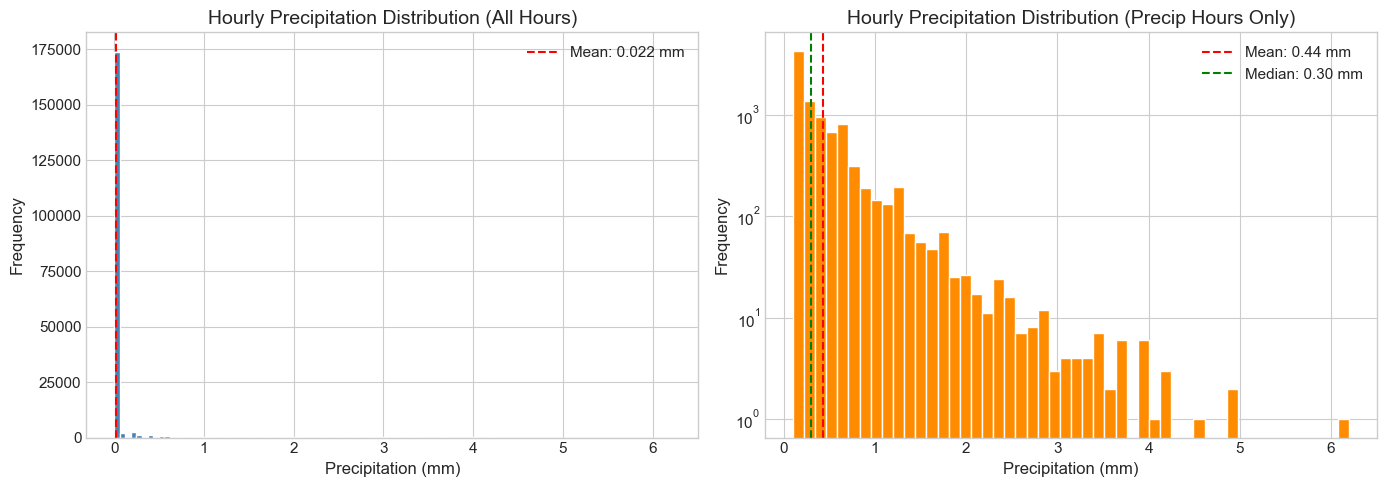


Precipitation Stats (hours with precip only):
  Mean: 0.44 mm
  Median: 0.30 mm
  Max: 6.20 mm
  95th percentile: 1.30 mm


In [25]:
# Distribution of Precipitation (Hourly)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All values (including zeros) - highly skewed
ax1 = axes[0]
df[PRECIP_COL].hist(bins=100, ax=ax1, color='steelblue', edgecolor='white')
ax1.set_xlabel('Precipitation (mm)')
ax1.set_ylabel('Frequency')
ax1.set_title('Hourly Precipitation Distribution (All Hours)')
ax1.axvline(df[PRECIP_COL].mean(), color='red', linestyle='--', 
            label=f'Mean: {df[PRECIP_COL].mean():.3f} mm')
ax1.legend()

# Right: Only precipitation hours (>0), log scale
ax2 = axes[1]
precip_only = df[df[PRECIP_COL] > 0][PRECIP_COL]
precip_only.hist(bins=50, ax=ax2, color='darkorange', edgecolor='white')
ax2.set_xlabel('Precipitation (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Hourly Precipitation Distribution (Precip Hours Only)')
ax2.set_yscale('log')
ax2.axvline(precip_only.mean(), color='red', linestyle='--', 
            label=f'Mean: {precip_only.mean():.2f} mm')
ax2.axvline(precip_only.median(), color='green', linestyle='--', 
            label=f'Median: {precip_only.median():.2f} mm')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nPrecipitation Stats (hours with precip only):")
print(f"  Mean: {precip_only.mean():.2f} mm")
print(f"  Median: {precip_only.median():.2f} mm")
print(f"  Max: {precip_only.max():.2f} mm")
print(f"  95th percentile: {precip_only.quantile(0.95):.2f} mm")


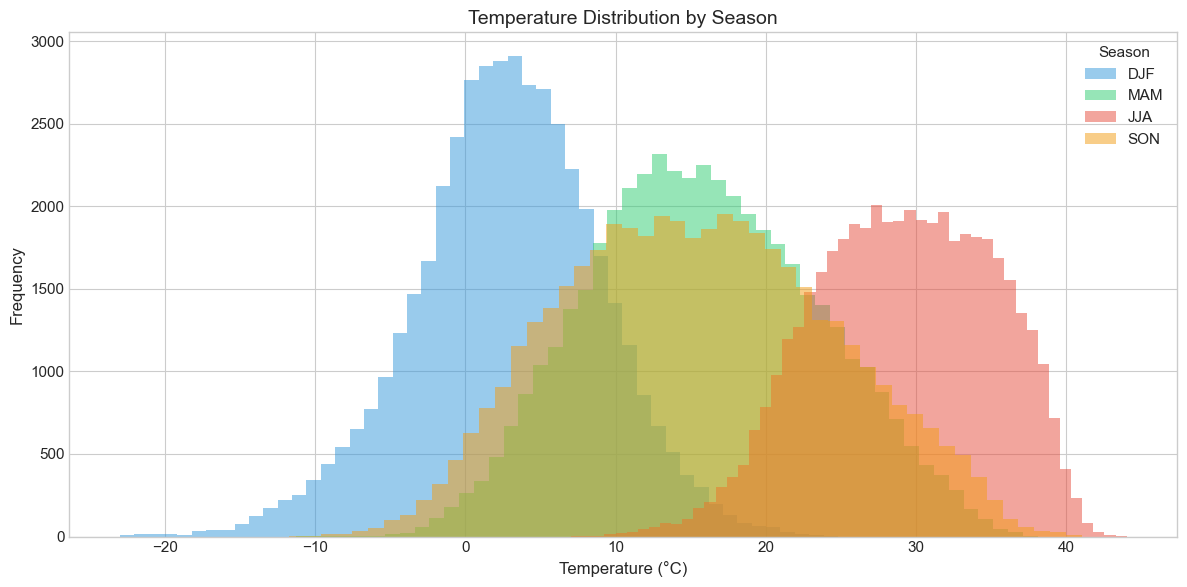

In [26]:
# Temperature Distribution by Season
fig, ax = plt.subplots(figsize=(12, 6))

season_order = ['DJF', 'MAM', 'JJA', 'SON']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, season in enumerate(season_order):
    season_data = df[df['Season'] == season][TEMP_COL]
    ax.hist(season_data, bins=50, alpha=0.5, label=season, color=colors[i])

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frequency')
ax.set_title('Temperature Distribution by Season')
ax.legend(title='Season')
plt.tight_layout()
plt.show()


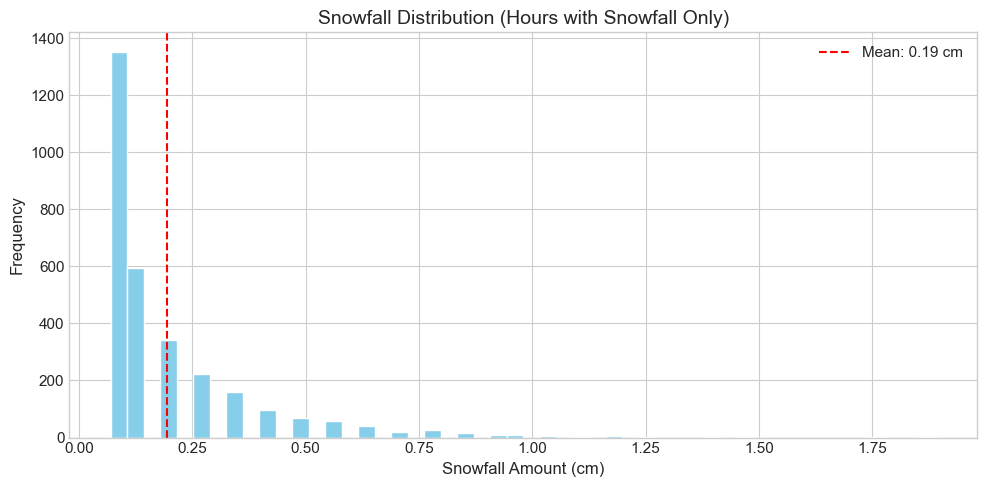

Snowfall Stats (hours with snow only):
  Total snow hours: 3,033
  Mean: 0.19 cm
  Max: 1.89 cm


In [27]:
# Snowfall Distribution (only months with snow)
if SNOW_COL in df.columns:
    snow_data = df[df[SNOW_COL] > 0][SNOW_COL]
    
    if len(snow_data) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        snow_data.hist(bins=50, ax=ax, color='skyblue', edgecolor='white')
        ax.set_xlabel('Snowfall Amount (cm)')
        ax.set_ylabel('Frequency')
        ax.set_title('Snowfall Distribution (Hours with Snowfall Only)')
        ax.axvline(snow_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: {snow_data.mean():.2f} cm')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Snowfall Stats (hours with snow only):")
        print(f"  Total snow hours: {len(snow_data):,}")
        print(f"  Mean: {snow_data.mean():.2f} cm")
        print(f"  Max: {snow_data.max():.2f} cm")
    else:
        print("No snowfall recorded in the dataset.")
else:
    print(f"Snowfall column '{SNOW_COL}' not found in dataset.")


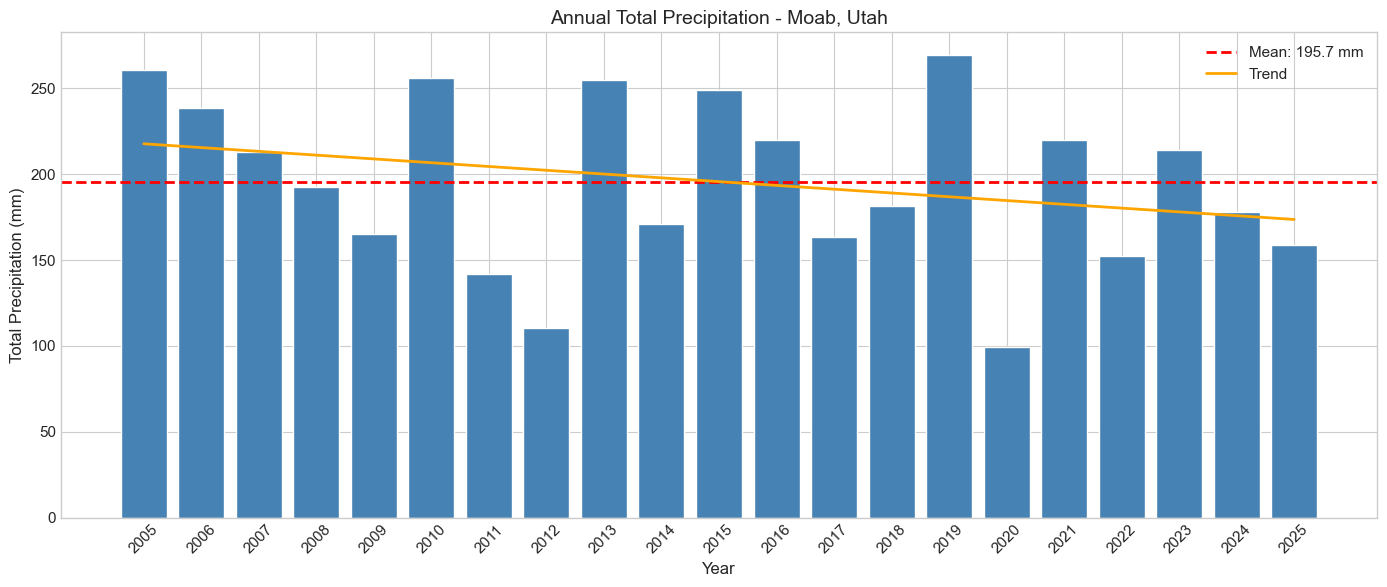


Annual Precipitation Summary:
  Mean: 195.7 mm
  Std Dev: 49.5 mm
  Min: 99.6 mm (2020)
  Max: 269.2 mm (2019)


In [28]:
# Annual Precipitation Totals - Time Series Overview
annual_precip = df.groupby('Year')[PRECIP_COL].sum()

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(annual_precip.index, annual_precip.values, color='steelblue', edgecolor='white')

# Add mean line
mean_annual = annual_precip.mean()
ax.axhline(mean_annual, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_annual:.1f} mm')

# Add trend line
z = np.polyfit(annual_precip.index, annual_precip.values, 1)
p = np.poly1d(z)
ax.plot(annual_precip.index, p(annual_precip.index), 
        color='orange', linewidth=2, linestyle='-', label='Trend')

ax.set_xlabel('Year')
ax.set_ylabel('Total Precipitation (mm)')
ax.set_title('Annual Total Precipitation - Moab, Utah')
ax.legend()
ax.set_xticks(annual_precip.index)
ax.set_xticklabels(annual_precip.index, rotation=45)

plt.tight_layout()
plt.show()

print(f"\nAnnual Precipitation Summary:")
print(f"  Mean: {annual_precip.mean():.1f} mm")
print(f"  Std Dev: {annual_precip.std():.1f} mm")
print(f"  Min: {annual_precip.min():.1f} mm ({annual_precip.idxmin()})")
print(f"  Max: {annual_precip.max():.1f} mm ({annual_precip.idxmax()})")


---
## 4. Monthly Analysis


In [29]:
# Calculate Monthly Total Precipitation for Each Year
monthly_totals = df.groupby(['Year', 'Month'])[PRECIP_COL].sum().reset_index()
monthly_totals.columns = ['Year', 'Month', 'Precip_Total_mm']

print("Monthly Total Precipitation (first 24 months):")
monthly_totals.head(24)


Monthly Total Precipitation (first 24 months):


,Year,Month,Precip_Total_mm
0,2005,1,64.9
1,2005,2,32.6
2,2005,3,29.5
3,2005,4,17.6
4,2005,5,3.9
5,2005,6,9.7
6,2005,7,0.5
7,2005,8,16.0
8,2005,9,28.7
9,2005,10,35.4


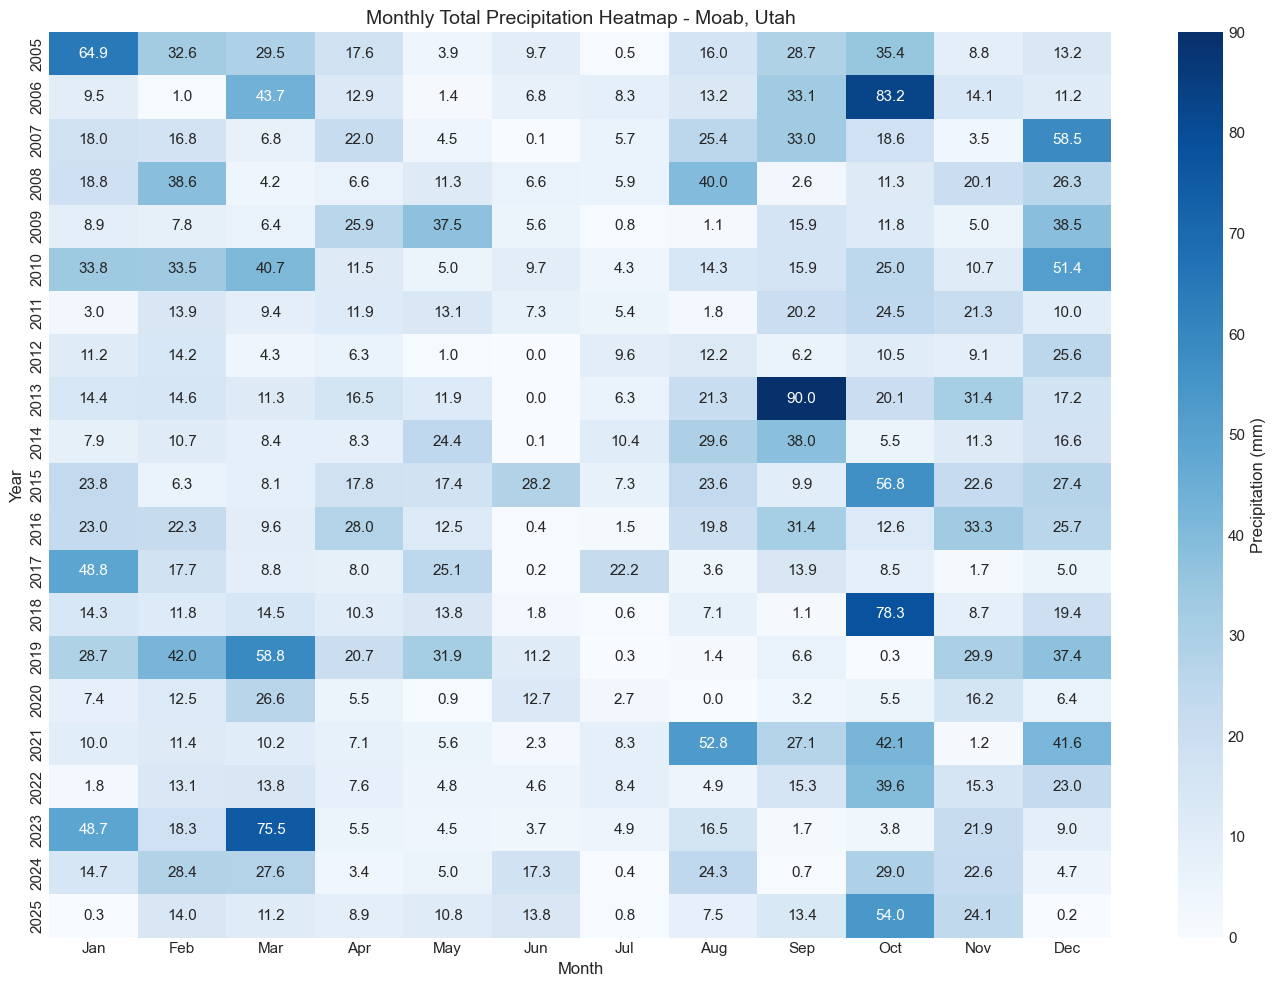

In [30]:
# Pivot for heatmap: Years × Months
monthly_pivot = monthly_totals.pivot(index='Year', columns='Month', values='Precip_Total_mm')

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.heatmap(monthly_pivot, 
            annot=True, 
            fmt='.1f', 
            cmap='Blues',
            cbar_kws={'label': 'Precipitation (mm)'},
            xticklabels=month_names,
            ax=ax)

ax.set_xlabel('Month')
ax.set_ylabel('Year')
ax.set_title('Monthly Total Precipitation Heatmap - Moab, Utah')

plt.tight_layout()
plt.show()


In [31]:
# Monthly Climatology (20-year average by month)
monthly_climatology = monthly_totals.groupby('Month')['Precip_Total_mm'].agg(['mean', 'std', 'min', 'max'])
monthly_climatology.columns = ['Mean', 'Std', 'Min', 'Max']
monthly_climatology.index = month_names

print("Monthly Precipitation Climatology (mm):")
print(monthly_climatology.round(1))


Monthly Precipitation Climatology (mm):
     Mean   Std  Min   Max
Jan  19.6  17.0  0.3  64.9
Feb  18.2  10.9  1.0  42.0
Mar  20.4  19.4  4.2  75.5
Apr  12.5   7.1  3.4  28.0
May  11.7  10.3  0.9  37.5
Jun   6.8   7.1  0.0  28.2
Jul   5.5   5.1  0.3  22.2
Aug  16.0  13.6  0.0  52.8
Sep  19.4  20.1  0.7  90.0
Oct  27.4  23.9  0.3  83.2
Nov  15.8   9.7  1.2  33.3
Dec  22.3  15.9  0.2  58.5


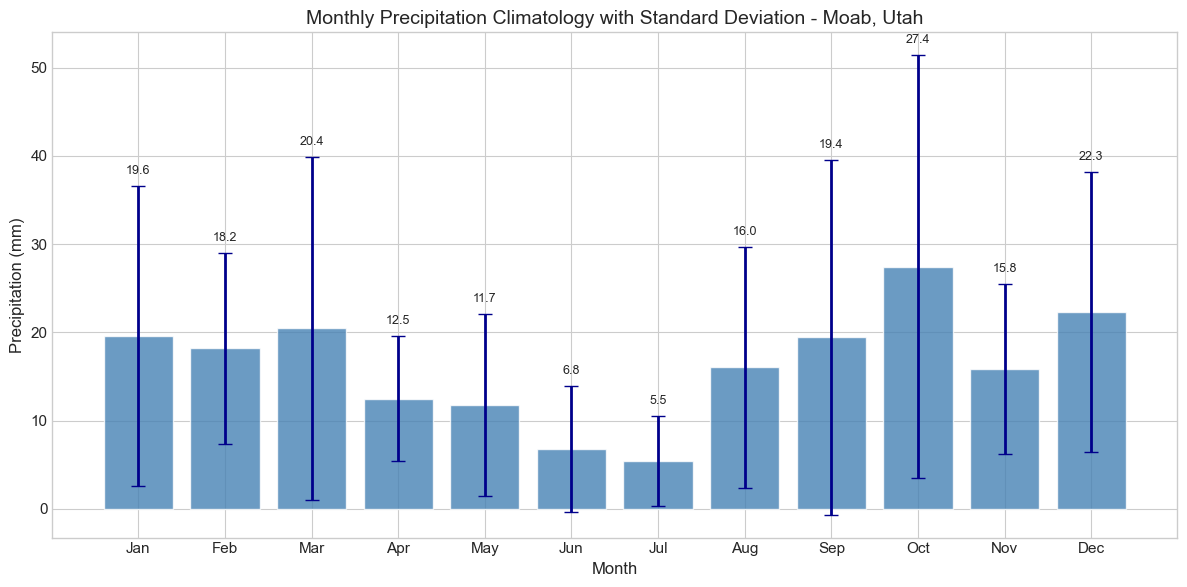

In [32]:
# Bar chart: Monthly climatology with error bars
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(12)
means = monthly_climatology['Mean'].values
stds = monthly_climatology['Std'].values

bars = ax.bar(x, means, yerr=stds, capsize=5, 
              color='steelblue', edgecolor='white', alpha=0.8,
              error_kw={'ecolor': 'darkblue', 'elinewidth': 2})

ax.set_xticks(x)
ax.set_xticklabels(month_names)
ax.set_xlabel('Month')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Monthly Precipitation Climatology with Standard Deviation - Moab, Utah')

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 1, f'{mean:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


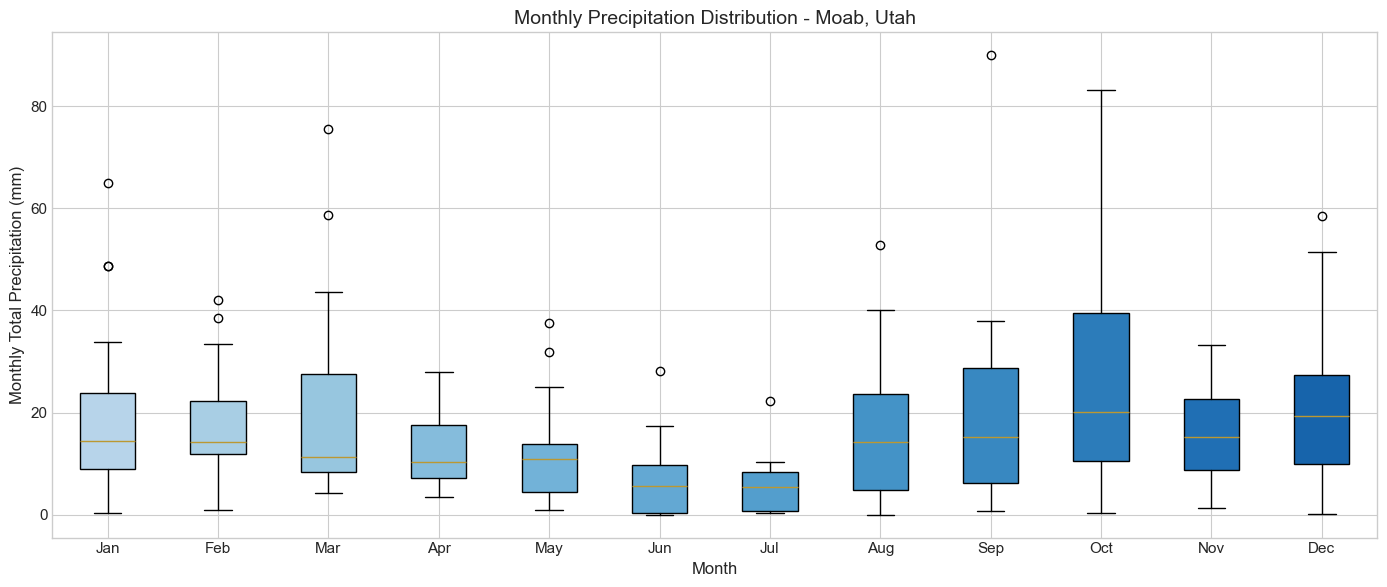

In [33]:
# Box plots: Precipitation distribution by month
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for boxplot
boxplot_data = [monthly_totals[monthly_totals['Month'] == m]['Precip_Total_mm'].values 
                for m in range(1, 13)]

bp = ax.boxplot(boxplot_data, patch_artist=True, labels=month_names)

# Color the boxes
colors = plt.cm.Blues(np.linspace(0.3, 0.8, 12))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Precipitation (mm)')
ax.set_title('Monthly Precipitation Distribution - Moab, Utah')

plt.tight_layout()
plt.show()


---
## 5. Seasonal Analysis


In [34]:
# Calculate Seasonal Totals for each Year
# Note: For DJF, December belongs to the following year's winter

def assign_season_year(row):
    """Assign the 'season year' - for DJF, December belongs to next year's winter."""
    if row['Month'] == 12:
        return row['Year'] + 1
    return row['Year']

df['SeasonYear'] = df.apply(assign_season_year, axis=1)

# Calculate seasonal totals
seasonal_totals = df.groupby(['SeasonYear', 'Season'])[PRECIP_COL].sum().reset_index()
seasonal_totals.columns = ['SeasonYear', 'Season', 'Precip_Total_mm']

# Remove incomplete seasons (first winter and last year if incomplete)
min_year = df['Year'].min()
max_year = df['Year'].max()
seasonal_totals = seasonal_totals[
    (seasonal_totals['SeasonYear'] > min_year) & 
    (seasonal_totals['SeasonYear'] <= max_year)
]

print("Seasonal Precipitation Totals (first 20 records):")
seasonal_totals.head(20)


Seasonal Precipitation Totals (first 20 records):


,SeasonYear,Season,Precip_Total_mm
4,2006,DJF,23.7
5,2006,JJA,28.3
6,2006,MAM,58.0
7,2006,SON,130.4
8,2007,DJF,46.0
9,2007,JJA,31.2
10,2007,MAM,33.3
11,2007,SON,55.1
12,2008,DJF,115.9
13,2008,JJA,52.5


In [35]:
# Seasonal Climatology
seasonal_climatology = seasonal_totals.groupby('Season')['Precip_Total_mm'].agg(['mean', 'std', 'min', 'max'])
seasonal_climatology.columns = ['Mean', 'Std', 'Min', 'Max']

# Reorder seasons
season_order = ['DJF', 'MAM', 'JJA', 'SON']
seasonal_climatology = seasonal_climatology.reindex(season_order)

print("Seasonal Precipitation Climatology (mm):")
print(seasonal_climatology.round(1))

print(f"\nTotal Annual Climatology: {seasonal_climatology['Mean'].sum():.1f} mm")


Seasonal Precipitation Climatology (mm):
        Mean   Std   Min    Max
Season                         
DJF     58.2  28.2  19.0  115.9
MAM     44.4  23.2  11.6  111.4
JJA     28.3  15.8   7.5   63.4
SON     62.2  33.7  24.1  141.5

Total Annual Climatology: 193.1 mm


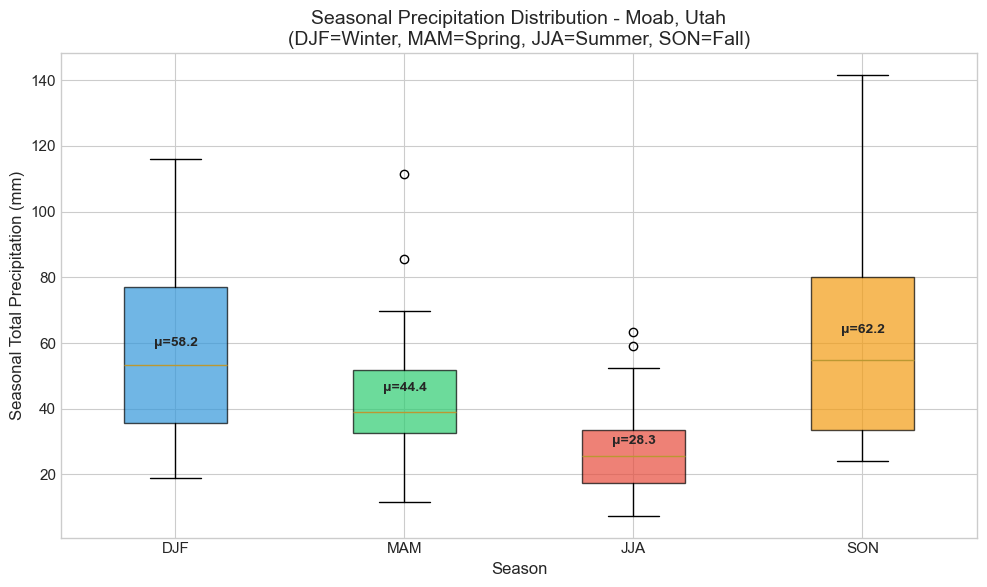

In [36]:
# Box plots: Seasonal comparison
fig, ax = plt.subplots(figsize=(10, 6))

season_colors = {'DJF': '#3498db', 'MAM': '#2ecc71', 'JJA': '#e74c3c', 'SON': '#f39c12'}

boxplot_data = [seasonal_totals[seasonal_totals['Season'] == s]['Precip_Total_mm'].values 
                for s in season_order]

bp = ax.boxplot(boxplot_data, patch_artist=True, labels=season_order)

for patch, season in zip(bp['boxes'], season_order):
    patch.set_facecolor(season_colors[season])
    patch.set_alpha(0.7)

ax.set_xlabel('Season')
ax.set_ylabel('Seasonal Total Precipitation (mm)')
ax.set_title('Seasonal Precipitation Distribution - Moab, Utah\n(DJF=Winter, MAM=Spring, JJA=Summer, SON=Fall)')

# Add mean values as text
for i, season in enumerate(season_order):
    mean_val = seasonal_climatology.loc[season, 'Mean']
    ax.text(i+1, mean_val, f'μ={mean_val:.1f}', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [37]:
# Warm vs Cold Season Analysis
df_warm = df[df['WarmCold'] == 'Warm']
df_cold = df[df['WarmCold'] == 'Cold']

# Calculate annual totals for warm and cold seasons
warm_annual = df_warm.groupby('Year')[PRECIP_COL].sum()
cold_annual = df_cold.groupby('Year')[PRECIP_COL].sum()

print("Warm Season (April-October) Precipitation:")
print(f"  Mean Annual Total: {warm_annual.mean():.1f} mm")
print(f"  Std Dev: {warm_annual.std():.1f} mm")

print("\nCold Season (November-March) Precipitation:")
print(f"  Mean Annual Total: {cold_annual.mean():.1f} mm")
print(f"  Std Dev: {cold_annual.std():.1f} mm")

print(f"\nWarm:Cold Ratio: {warm_annual.mean()/cold_annual.mean():.2f}")


Warm Season (April-October) Precipitation:
  Mean Annual Total: 99.3 mm
  Std Dev: 37.5 mm

Cold Season (November-March) Precipitation:
  Mean Annual Total: 96.4 mm
  Std Dev: 42.1 mm

Warm:Cold Ratio: 1.03


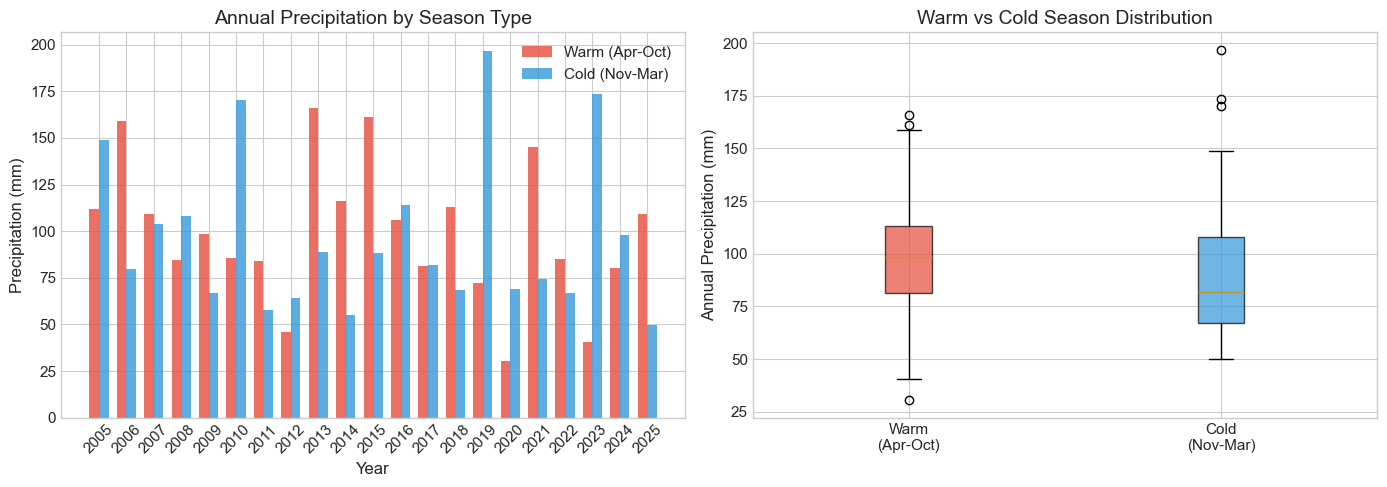

In [38]:
# Warm vs Cold - Side by side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time series comparison
ax1 = axes[0]
years = warm_annual.index
width = 0.35
x = np.arange(len(years))

ax1.bar(x - width/2, warm_annual.values, width, label='Warm (Apr-Oct)', color='#e74c3c', alpha=0.8)
ax1.bar(x + width/2, cold_annual.values, width, label='Cold (Nov-Mar)', color='#3498db', alpha=0.8)

ax1.set_xlabel('Year')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title('Annual Precipitation by Season Type')
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)
ax1.legend()

# Right: Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([warm_annual.values, cold_annual.values], 
                  patch_artist=True, labels=['Warm\n(Apr-Oct)', 'Cold\n(Nov-Mar)'])

bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('#3498db')
bp['boxes'][1].set_alpha(0.7)

ax2.set_ylabel('Annual Precipitation (mm)')
ax2.set_title('Warm vs Cold Season Distribution')

plt.tight_layout()
plt.show()


---
## 6. Client-Ready Visualizations


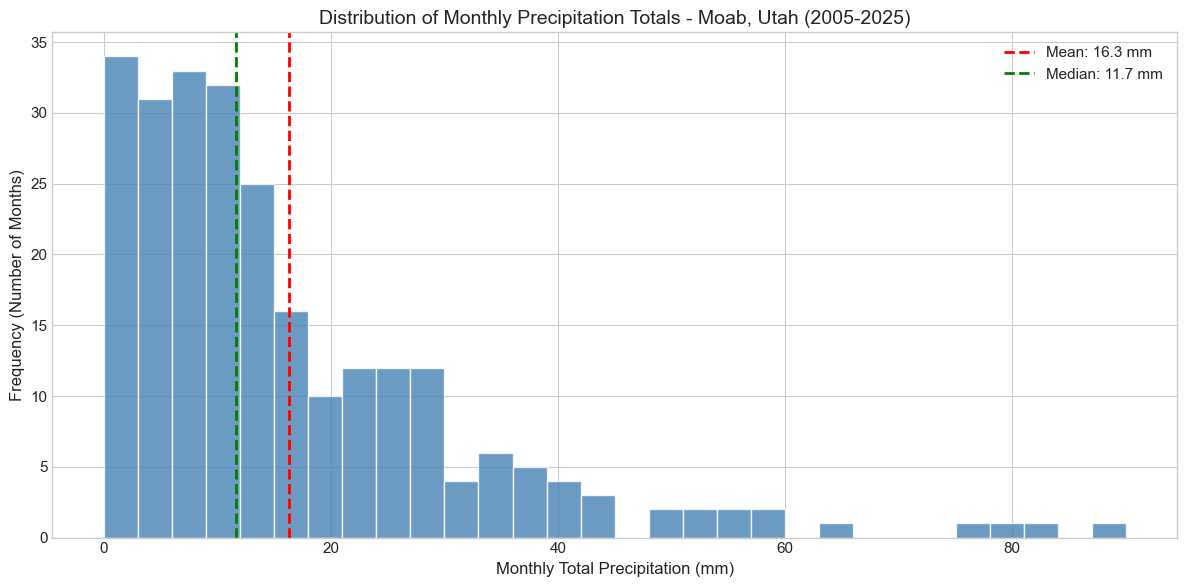

Saved: monthly_precip_histogram.png


In [39]:
# Histogram: Monthly Precipitation Distribution
fig, ax = plt.subplots(figsize=(12, 6))

monthly_totals['Precip_Total_mm'].hist(bins=30, ax=ax, 
                                        color='steelblue', 
                                        edgecolor='white',
                                        alpha=0.8)

ax.axvline(monthly_totals['Precip_Total_mm'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Mean: {monthly_totals["Precip_Total_mm"].mean():.1f} mm')
ax.axvline(monthly_totals['Precip_Total_mm'].median(), color='green', 
           linestyle='--', linewidth=2, label=f'Median: {monthly_totals["Precip_Total_mm"].median():.1f} mm')

ax.set_xlabel('Monthly Total Precipitation (mm)', fontsize=12)
ax.set_ylabel('Frequency (Number of Months)', fontsize=12)
ax.set_title('Distribution of Monthly Precipitation Totals - Moab, Utah (2005-2025)', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('monthly_precip_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: monthly_precip_histogram.png")


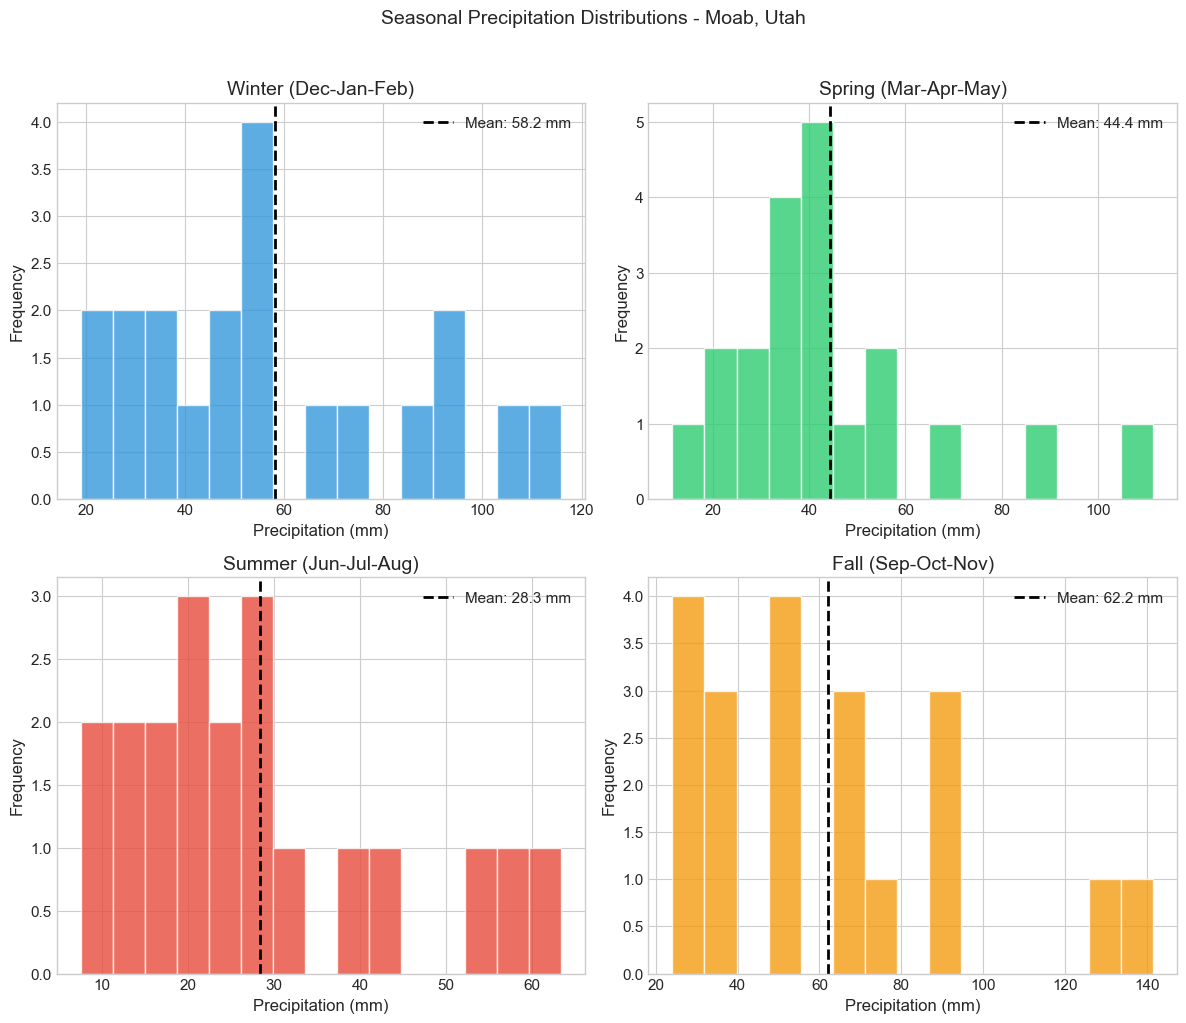

Saved: seasonal_precip_histograms.png


In [40]:
# Histogram: Seasonal Precipitation Distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

season_names = {'DJF': 'Winter (Dec-Jan-Feb)', 
                'MAM': 'Spring (Mar-Apr-May)', 
                'JJA': 'Summer (Jun-Jul-Aug)', 
                'SON': 'Fall (Sep-Oct-Nov)'}

for ax, season in zip(axes.flat, season_order):
    data = seasonal_totals[seasonal_totals['Season'] == season]['Precip_Total_mm']
    
    ax.hist(data, bins=15, color=season_colors[season], edgecolor='white', alpha=0.8)
    ax.axvline(data.mean(), color='black', linestyle='--', linewidth=2,
               label=f'Mean: {data.mean():.1f} mm')
    
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Frequency')
    ax.set_title(season_names[season])
    ax.legend()

fig.suptitle('Seasonal Precipitation Distributions - Moab, Utah', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('seasonal_precip_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: seasonal_precip_histograms.png")


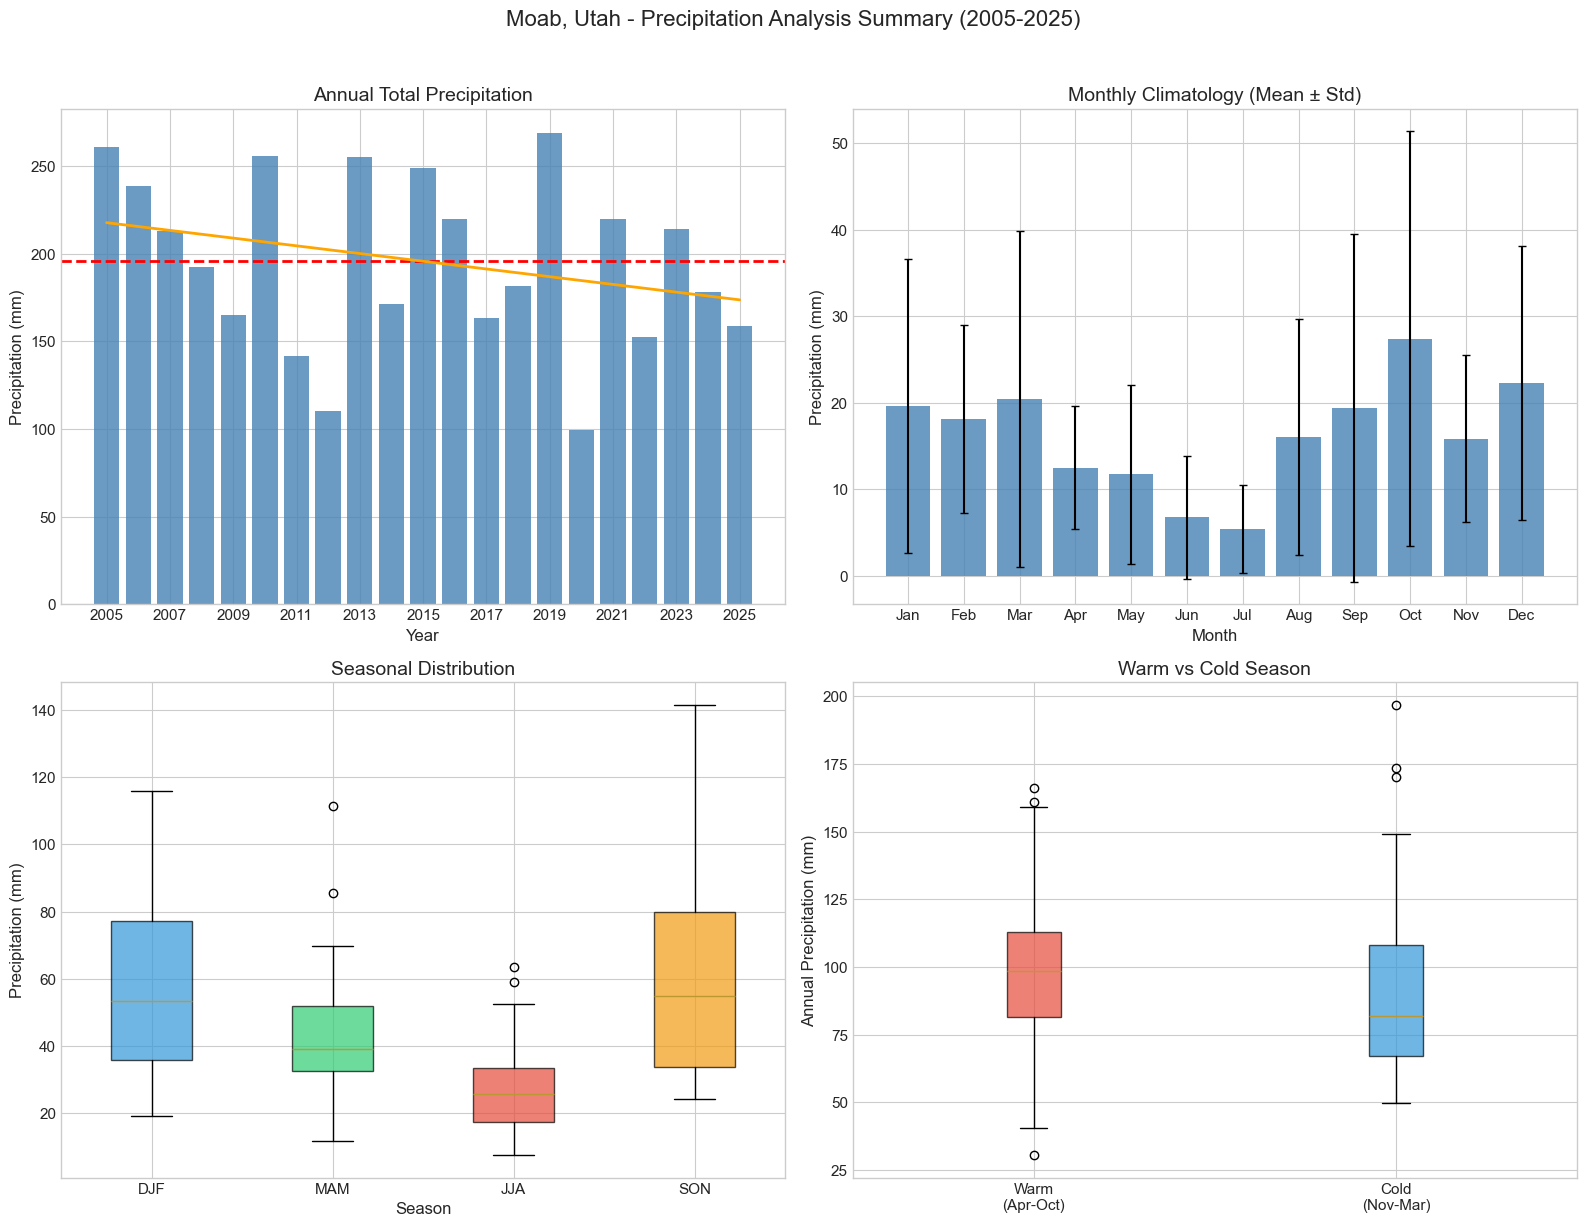

Saved: moab_precip_summary.png


In [41]:
# Combined Summary Figure
fig = plt.figure(figsize=(16, 12))

# Top left: Annual trend
ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(annual_precip.index, annual_precip.values, color='steelblue', alpha=0.8)
ax1.axhline(annual_precip.mean(), color='red', linestyle='--', linewidth=2)
z = np.polyfit(annual_precip.index, annual_precip.values, 1)
p = np.poly1d(z)
ax1.plot(annual_precip.index, p(annual_precip.index), color='orange', linewidth=2)
ax1.set_xlabel('Year')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title('Annual Total Precipitation')
ax1.set_xticks(annual_precip.index[::2])

# Top right: Monthly climatology
ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(range(12), monthly_climatology['Mean'].values, 
        yerr=monthly_climatology['Std'].values, capsize=3,
        color='steelblue', alpha=0.8)
ax2.set_xticks(range(12))
ax2.set_xticklabels(month_names)
ax2.set_xlabel('Month')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title('Monthly Climatology (Mean ± Std)')

# Bottom left: Seasonal boxplots
ax3 = fig.add_subplot(2, 2, 3)
boxdata = [seasonal_totals[seasonal_totals['Season'] == s]['Precip_Total_mm'].values 
           for s in season_order]
bp = ax3.boxplot(boxdata, patch_artist=True, labels=season_order)
for patch, season in zip(bp['boxes'], season_order):
    patch.set_facecolor(season_colors[season])
    patch.set_alpha(0.7)
ax3.set_xlabel('Season')
ax3.set_ylabel('Precipitation (mm)')
ax3.set_title('Seasonal Distribution')

# Bottom right: Warm vs Cold
ax4 = fig.add_subplot(2, 2, 4)
bp2 = ax4.boxplot([warm_annual.values, cold_annual.values], 
                   patch_artist=True, labels=['Warm\n(Apr-Oct)', 'Cold\n(Nov-Mar)'])
bp2['boxes'][0].set_facecolor('#e74c3c')
bp2['boxes'][0].set_alpha(0.7)
bp2['boxes'][1].set_facecolor('#3498db')
bp2['boxes'][1].set_alpha(0.7)
ax4.set_ylabel('Annual Precipitation (mm)')
ax4.set_title('Warm vs Cold Season')

fig.suptitle('Moab, Utah - Precipitation Analysis Summary (2005-2025)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('moab_precip_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: moab_precip_summary.png")


---
## 7. Operating Period vs Climatology Comparison


In [42]:
# Define periods based on configuration at top of notebook
print("Period Definitions:")
print(f"  Operating Period: {OPERATING_PERIOD_START} to {OPERATING_PERIOD_END}")
print(f"  Baseline Climatology: {CLIMATOLOGY_START} to {CLIMATOLOGY_END}")

# Filter data by periods
op_start = pd.to_datetime(OPERATING_PERIOD_START)
op_end = pd.to_datetime(OPERATING_PERIOD_END)
clim_start = pd.to_datetime(CLIMATOLOGY_START)
clim_end = pd.to_datetime(CLIMATOLOGY_END)

df_operating = df[(df['timestamp'] >= op_start) & (df['timestamp'] <= op_end)]
df_climatology = df[(df['timestamp'] >= clim_start) & (df['timestamp'] <= clim_end)]

print(f"\nOperating period records: {len(df_operating):,}")
print(f"Climatology period records: {len(df_climatology):,}")


Period Definitions:
  Operating Period: 2020-01-01 to 2025-12-31
  Baseline Climatology: 2005-01-01 to 2019-12-31

Operating period records: 51,912
Climatology period records: 131,449


In [43]:
# Calculate monthly totals for each period
monthly_op = df_operating.groupby(['Year', 'Month'])[PRECIP_COL].sum().reset_index()
monthly_op.columns = ['Year', 'Month', 'Precip_mm']

monthly_clim = df_climatology.groupby(['Year', 'Month'])[PRECIP_COL].sum().reset_index()
monthly_clim.columns = ['Year', 'Month', 'Precip_mm']

# Calculate annual totals
annual_op = df_operating.groupby('Year')[PRECIP_COL].sum()
annual_clim = df_climatology.groupby('Year')[PRECIP_COL].sum()

print("Annual Totals - Operating Period:")
print(annual_op)
print(f"\nMean: {annual_op.mean():.1f} mm")

print("\nAnnual Totals - Climatology Period:")
print(annual_clim)
print(f"\nMean: {annual_clim.mean():.1f} mm")


Annual Totals - Operating Period:
Year
2020     99.6
2021    219.7
2022    152.2
2023    214.0
2024    178.1
2025    159.0
Name: Precipitation_Total, dtype: float64

Mean: 170.4 mm

Annual Totals - Climatology Period:
Year
2005    260.8
2006    238.4
2007    212.9
2008    192.3
2009    165.2
2010    255.8
2011    141.8
2012    110.2
2013    255.0
2014    171.2
2015    249.2
2016    220.1
2017    163.5
2018    181.7
2019    269.2
Name: Precipitation_Total, dtype: float64

Mean: 205.8 mm


In [44]:
# Statistical Tests
print("=" * 60)
print("STATISTICAL COMPARISON: Operating Period vs Climatology")
print("=" * 60)

# 1. Compare monthly totals
op_monthly = monthly_op['Precip_mm'].values
clim_monthly = monthly_clim['Precip_mm'].values

print("\n1. MONTHLY PRECIPITATION COMPARISON")
print("-" * 40)
print(f"Operating Period: Mean = {op_monthly.mean():.2f} mm, Std = {op_monthly.std():.2f} mm")
print(f"Climatology:      Mean = {clim_monthly.mean():.2f} mm, Std = {clim_monthly.std():.2f} mm")

# T-test (parametric)
t_stat, t_pval = stats.ttest_ind(op_monthly, clim_monthly)
print(f"\nt-test: t = {t_stat:.3f}, p-value = {t_pval:.4f}")
if t_pval < 0.05:
    print("  → Statistically significant difference at α=0.05")
else:
    print("  → No statistically significant difference at α=0.05")

# Mann-Whitney U test (non-parametric - better for skewed data)
u_stat, u_pval = stats.mannwhitneyu(op_monthly, clim_monthly, alternative='two-sided')
print(f"\nMann-Whitney U test: U = {u_stat:.1f}, p-value = {u_pval:.4f}")
if u_pval < 0.05:
    print("  → Statistically significant difference at α=0.05")
else:
    print("  → No statistically significant difference at α=0.05")

# Kolmogorov-Smirnov test (compare distributions)
ks_stat, ks_pval = stats.ks_2samp(op_monthly, clim_monthly)
print(f"\nKolmogorov-Smirnov test: D = {ks_stat:.3f}, p-value = {ks_pval:.4f}")
if ks_pval < 0.05:
    print("  → Distributions are significantly different at α=0.05")
else:
    print("  → Distributions are not significantly different at α=0.05")

# Effect size (Cohen's d)
pooled_std = np.sqrt((op_monthly.std()**2 + clim_monthly.std()**2) / 2)
cohens_d = (op_monthly.mean() - clim_monthly.mean()) / pooled_std
print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print("  → Negligible effect")
elif abs(cohens_d) < 0.5:
    print("  → Small effect")
elif abs(cohens_d) < 0.8:
    print("  → Medium effect")
else:
    print("  → Large effect")


STATISTICAL COMPARISON: Operating Period vs Climatology

1. MONTHLY PRECIPITATION COMPARISON
----------------------------------------
Operating Period: Mean = 14.20 mm, Std = 14.65 mm
Climatology:      Mean = 17.15 mm, Std = 15.64 mm

t-test: t = -1.371, p-value = 0.1715
  → No statistically significant difference at α=0.05

Mann-Whitney U test: U = 5480.5, p-value = 0.0560
  → No statistically significant difference at α=0.05

Kolmogorov-Smirnov test: D = 0.175, p-value = 0.0777
  → Distributions are not significantly different at α=0.05

Effect size (Cohen's d): -0.195
  → Negligible effect


In [45]:
# Seasonal comparison
print("\n2. SEASONAL PRECIPITATION COMPARISON")
print("-" * 40)

seasonal_op = df_operating.groupby(['SeasonYear', 'Season'])[PRECIP_COL].sum().reset_index()
seasonal_clim = df_climatology.groupby(['SeasonYear', 'Season'])[PRECIP_COL].sum().reset_index()

for season in season_order:
    op_season = seasonal_op[seasonal_op['Season'] == season][PRECIP_COL].values
    clim_season = seasonal_clim[seasonal_clim['Season'] == season][PRECIP_COL].values
    
    if len(op_season) > 1 and len(clim_season) > 1:
        u_stat, u_pval = stats.mannwhitneyu(op_season, clim_season, alternative='two-sided')
        sig_marker = "*" if u_pval < 0.05 else ""
        
        print(f"\n{season}:")
        print(f"  Operating: {op_season.mean():.1f} ± {op_season.std():.1f} mm")
        print(f"  Climatology: {clim_season.mean():.1f} ± {clim_season.std():.1f} mm")
        print(f"  Mann-Whitney p = {u_pval:.4f} {sig_marker}")



2. SEASONAL PRECIPITATION COMPARISON
----------------------------------------

DJF:
  Operating: 37.9 ± 27.9 mm
  Climatology: 62.3 ± 28.8 mm
  Mann-Whitney p = 0.0762 

MAM:
  Operating: 39.1 ± 21.2 mm
  Climatology: 46.9 ± 22.1 mm
  Mann-Whitney p = 0.1537 

JJA:
  Operating: 31.0 ± 16.8 mm
  Climatology: 27.1 ± 14.1 mm
  Mann-Whitney p = 0.8456 

SON:
  Operating: 56.1 ± 24.0 mm
  Climatology: 65.4 ± 34.5 mm
  Mann-Whitney p = 0.7333 


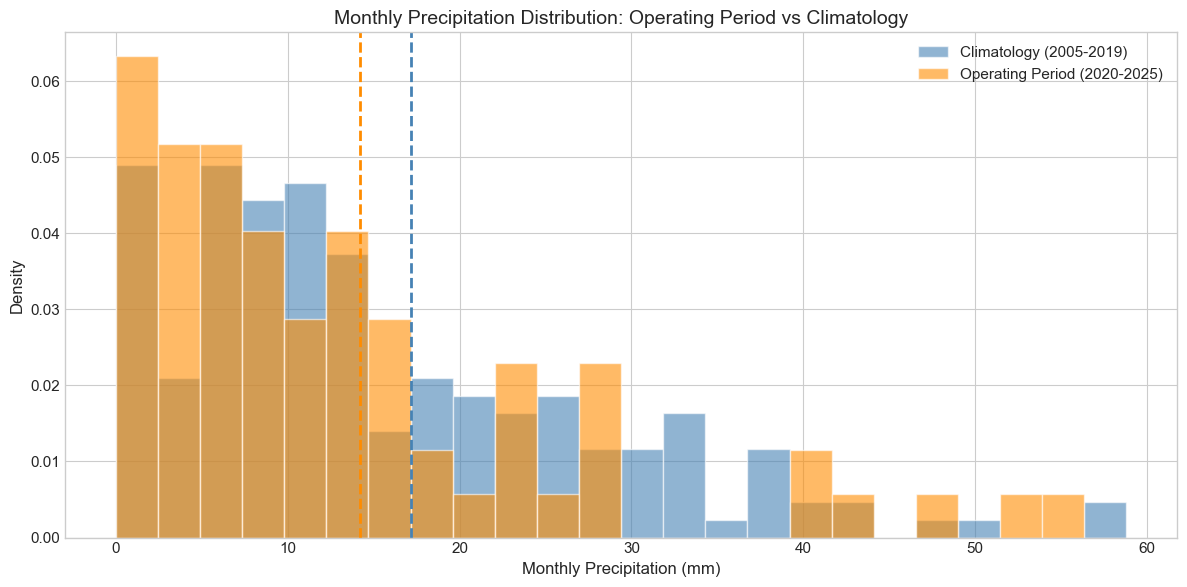

Saved: operating_vs_climatology_histogram.png


In [46]:
# Overlay histograms: Operating vs Climatology
fig, ax = plt.subplots(figsize=(12, 6))

# Determine common bin edges
all_data = np.concatenate([op_monthly, clim_monthly])
bins = np.linspace(0, np.percentile(all_data, 98), 25)

ax.hist(clim_monthly, bins=bins, alpha=0.6, label=f'Climatology ({CLIMATOLOGY_START[:4]}-{CLIMATOLOGY_END[:4]})',
        color='steelblue', edgecolor='white', density=True)
ax.hist(op_monthly, bins=bins, alpha=0.6, label=f'Operating Period ({OPERATING_PERIOD_START[:4]}-{OPERATING_PERIOD_END[:4]})',
        color='darkorange', edgecolor='white', density=True)

ax.axvline(clim_monthly.mean(), color='steelblue', linestyle='--', linewidth=2)
ax.axvline(op_monthly.mean(), color='darkorange', linestyle='--', linewidth=2)

ax.set_xlabel('Monthly Precipitation (mm)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Monthly Precipitation Distribution: Operating Period vs Climatology', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('operating_vs_climatology_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: operating_vs_climatology_histogram.png")


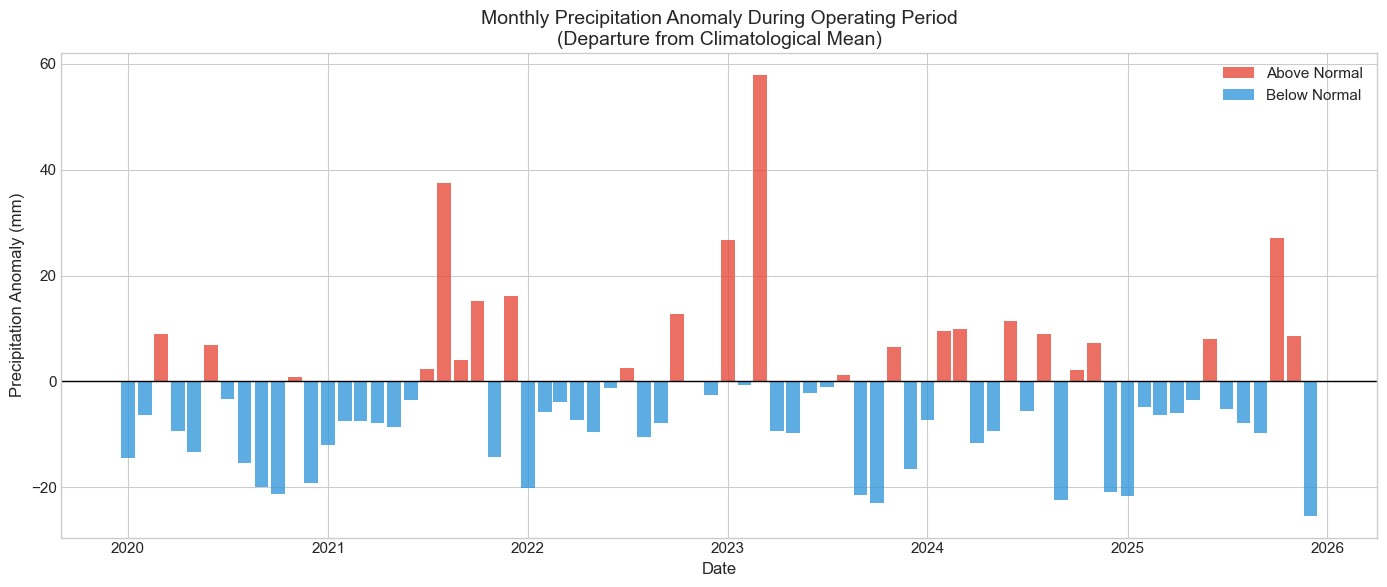

Saved: precipitation_anomaly.png


In [47]:
# Anomaly plot: Monthly departure from climatology
# Calculate climatological mean for each month
clim_monthly_means = monthly_clim.groupby('Month')['Precip_mm'].mean()

# Calculate anomalies for operating period
monthly_op_with_anom = monthly_op.copy()
monthly_op_with_anom['Climatology'] = monthly_op_with_anom['Month'].map(clim_monthly_means)
monthly_op_with_anom['Anomaly'] = monthly_op_with_anom['Precip_mm'] - monthly_op_with_anom['Climatology']
monthly_op_with_anom['Anomaly_pct'] = (monthly_op_with_anom['Anomaly'] / monthly_op_with_anom['Climatology']) * 100

# Create date index for plotting
monthly_op_with_anom['Date'] = pd.to_datetime(
    monthly_op_with_anom['Year'].astype(str) + '-' + 
    monthly_op_with_anom['Month'].astype(str).str.zfill(2) + '-01'
)

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#e74c3c' if x > 0 else '#3498db' for x in monthly_op_with_anom['Anomaly']]
ax.bar(monthly_op_with_anom['Date'], monthly_op_with_anom['Anomaly'], 
       color=colors, alpha=0.8, width=25)

ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Precipitation Anomaly (mm)', fontsize=12)
ax.set_title('Monthly Precipitation Anomaly During Operating Period\n(Departure from Climatological Mean)', fontsize=14)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', alpha=0.8, label='Above Normal'),
                   Patch(facecolor='#3498db', alpha=0.8, label='Below Normal')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('precipitation_anomaly.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: precipitation_anomaly.png")


In [48]:
# Summary Table
print("\n" + "=" * 80)
print("SUMMARY TABLE: Operating Period vs Climatology")
print("=" * 80)

summary_data = {
    'Metric': ['Annual Total (mm)', 'Monthly Mean (mm)', 'Monthly Std (mm)', 
               'DJF Mean (mm)', 'MAM Mean (mm)', 'JJA Mean (mm)', 'SON Mean (mm)'],
    'Operating Period': [
        f"{annual_op.mean():.1f}",
        f"{op_monthly.mean():.1f}",
        f"{op_monthly.std():.1f}",
        f"{seasonal_op[seasonal_op['Season']=='DJF'][PRECIP_COL].mean():.1f}" if len(seasonal_op[seasonal_op['Season']=='DJF']) > 0 else 'N/A',
        f"{seasonal_op[seasonal_op['Season']=='MAM'][PRECIP_COL].mean():.1f}" if len(seasonal_op[seasonal_op['Season']=='MAM']) > 0 else 'N/A',
        f"{seasonal_op[seasonal_op['Season']=='JJA'][PRECIP_COL].mean():.1f}" if len(seasonal_op[seasonal_op['Season']=='JJA']) > 0 else 'N/A',
        f"{seasonal_op[seasonal_op['Season']=='SON'][PRECIP_COL].mean():.1f}" if len(seasonal_op[seasonal_op['Season']=='SON']) > 0 else 'N/A'
    ],
    'Climatology': [
        f"{annual_clim.mean():.1f}",
        f"{clim_monthly.mean():.1f}",
        f"{clim_monthly.std():.1f}",
        f"{seasonal_clim[seasonal_clim['Season']=='DJF'][PRECIP_COL].mean():.1f}" if len(seasonal_clim[seasonal_clim['Season']=='DJF']) > 0 else 'N/A',
        f"{seasonal_clim[seasonal_clim['Season']=='MAM'][PRECIP_COL].mean():.1f}" if len(seasonal_clim[seasonal_clim['Season']=='MAM']) > 0 else 'N/A',
        f"{seasonal_clim[seasonal_clim['Season']=='JJA'][PRECIP_COL].mean():.1f}" if len(seasonal_clim[seasonal_clim['Season']=='JJA']) > 0 else 'N/A',
        f"{seasonal_clim[seasonal_clim['Season']=='SON'][PRECIP_COL].mean():.1f}" if len(seasonal_clim[seasonal_clim['Season']=='SON']) > 0 else 'N/A'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))



SUMMARY TABLE: Operating Period vs Climatology
           Metric Operating Period Climatology
Annual Total (mm)            170.4       205.8
Monthly Mean (mm)             14.2        17.2
 Monthly Std (mm)             14.7        15.6
    DJF Mean (mm)             37.9        62.3
    MAM Mean (mm)             39.1        46.9
    JJA Mean (mm)             31.0        27.1
    SON Mean (mm)             56.1        65.4


In [49]:
# Statistical Test Results Summary
print("\n" + "=" * 80)
print("STATISTICAL TEST RESULTS")
print("=" * 80)

test_results = {
    'Test': ['Student\'s t-test', 'Mann-Whitney U', 'Kolmogorov-Smirnov'],
    'Statistic': [f"{t_stat:.3f}", f"{u_stat:.1f}", f"{ks_stat:.3f}"],
    'p-value': [f"{t_pval:.4f}", f"{u_pval:.4f}", f"{ks_pval:.4f}"],
    'Significant (α=0.05)': ['Yes' if t_pval < 0.05 else 'No',
                             'Yes' if u_pval < 0.05 else 'No',
                             'Yes' if ks_pval < 0.05 else 'No']
}

test_df = pd.DataFrame(test_results)
print(test_df.to_string(index=False))

print(f"\nEffect Size (Cohen's d): {cohens_d:.3f}")
print("\nInterpretation Guide:")
print("  • p < 0.05: The difference is statistically significant")
print("  • Cohen's d: |d| < 0.2 (negligible), 0.2-0.5 (small), 0.5-0.8 (medium), > 0.8 (large)")



STATISTICAL TEST RESULTS
              Test Statistic p-value Significant (α=0.05)
  Student's t-test    -1.371  0.1715                   No
    Mann-Whitney U      40.0  0.7333                   No
Kolmogorov-Smirnov     0.175  0.0777                   No

Effect Size (Cohen's d): -0.195

Interpretation Guide:
  • p < 0.05: The difference is statistically significant
  • Cohen's d: |d| < 0.2 (negligible), 0.2-0.5 (small), 0.5-0.8 (medium), > 0.8 (large)


---
## Client-Friendly Summary

### Key Findings

The analysis above provides:

1. **Monthly Precipitation Patterns**: Heatmap and climatology showing which months are typically wetter/drier

2. **Seasonal Patterns**: 
   - DJF (Winter), MAM (Spring), JJA (Summer), SON (Fall) breakdown
   - Warm (Apr-Oct) vs Cold (Nov-Mar) season comparison

3. **Operating Period Assessment**:
   - Statistical comparison of your operating period to the historical baseline
   - Anomaly plots showing departures from normal conditions
   - Multiple statistical tests for robust conclusions

### How to Use This Information

- **If p-value < 0.05**: The operating period precipitation is statistically different from historical norms
- **Positive anomalies**: Operating period was wetter than normal
- **Negative anomalies**: Operating period was drier than normal
- **Effect size**: Tells you the practical significance (even statistically significant differences may be small in absolute terms)


In [50]:
# Save processed data for further analysis
monthly_totals.to_csv('moab_monthly_totals.csv', index=False)
seasonal_totals.to_csv('moab_seasonal_totals.csv', index=False)
print("Data exported:")
print("  - moab_monthly_totals.csv")
print("  - moab_seasonal_totals.csv")


Data exported:
  - moab_monthly_totals.csv
  - moab_seasonal_totals.csv
